In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [5]:
# The data is in https://drive.google.com/file/d/1n9gjLCxzFe8N2QbHeZkDtswlSdNyJpEs/view?usp=drive_link
test_data = np.load("./test_dataset.npy")
print("Test data shape: ", test_data.shape)

Test data shape:  (4, 320, 256, 256)


In [7]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

In [8]:
'''
Reading the pretrained parameters
'''
model = SimpleUNet()
# The pretrained model is in https://drive.google.com/file/d/16W_aeHeB-yBHSFRfo1ILJh3DbahkUiRT/view?usp=drive_link
state_dict = torch.load('trained_model_data_assimilation.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

In [9]:
def denoise(x_t, conditions, model, steps=1000):
    betas = torch.linspace(1e-4, 0.02, steps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    for t in reversed(range(1, steps+1)):
        # the dimension of x_t should be (batch_size, 1, height, width) and remains the same for all the time steps
        # x_t denotes the noised snapshot
        # Two additional channels are added to x_t: the conditions and the normalized time step
        # The input of the model has therefore 3 channels
        # The output of the model is the predicted noise with a single channel
        # The output of the model is used to calculate the previous step (x_{t-1}) in the backward process of the diffusion model
        assert x_t.shape[1] == 1, f"Error: The channel of x_t != 1."  # Make sure the input is a single channel snapshot
        # Add the conditions to x_t as the second channel
        x_t_with_conditions = torch.cat((x_t, conditions), dim=1) # This is your task. Complete this line of code. Only one line of code is needed
        assert x_t_with_conditions.shape[1] == 2, f"Error: The channel of x_t_with_conditions != 2."   
        # Add the normalized time step (normalize by divided by the number of the total steps) as the third channel
        nomalized_t = t / (steps)
        time_step_channel = torch.ones_like(x_t) * nomalized_t
        time_step_channel = time_step_channel.to(device)
        x_t_with_conditions_and_time_step = torch.cat((x_t_with_conditions, time_step_channel), dim=1)
        assert x_t_with_conditions_and_time_step.shape[1] == 3, f"Error: The channel of x_t_with_conditions_and_time_step != 3."   
        # Calculate the parameters
        alpha_t_bar = alphas_cumprod[t-1]
        beta_t = betas[t-1]
        alpha_t = alphas[t-1]

        # Predict the noise using the model
        with torch.no_grad():
            epsilon_theta = model(x_t_with_conditions_and_time_step)
        
        # Make sure the output of the model (the predicted noise) has a single channel 
        assert epsilon_theta.shape[1] == 1, "Error: The channel of epsilon_theta != 1."  
        # Calculate the mean of the previous step in the backward process of diffusion model
        mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_t_bar)) * epsilon_theta)  
        # Add noise for all but the last step (strictly follow the algorithm)
        if t > 1:
            # z = torch.randn_like(x_t).to(device)
            z = torch.randn_like(x_t).to(device)
            x_t = mean + torch.sqrt(beta_t) * z
        else:
            x_t = mean
        
    return x_t

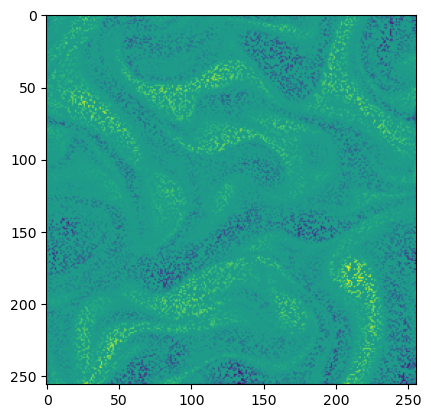

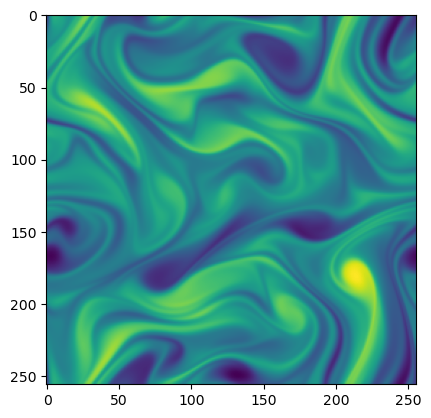

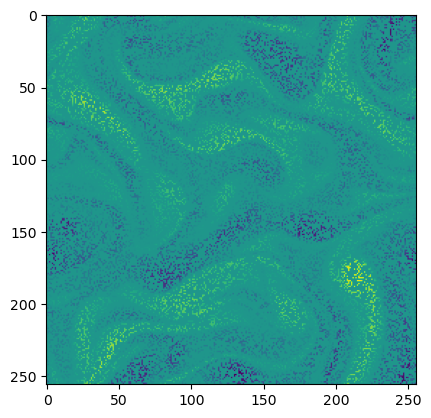

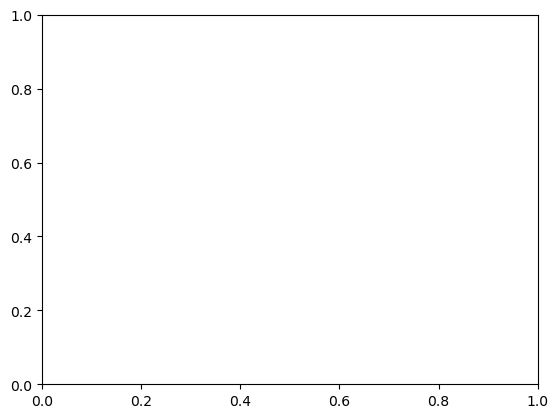

In [11]:

# Choose snapshot from test dataset: [4, 320, 256, 256] by changing the first dimension and the second dimension 
# Make sure that the first and the second dimensions are within the range of the test dataset 
test_snapshot = test_data[1, 110, :, :] # 1 and 110 are chosen here, you change them to get different snapshots

percentage = 30
factor = percentage/100
N = int(256**2 * factor)
test_snapshot = test_data[3, 79, :, :]
nx = np.random.randint(0, 256, (N,))
ny = np.random.randint(0, 256, (N,))
sparse_measurement =  test_snapshot[nx, ny]
xx,yy = np.meshgrid(np.arange(256), np.arange(256))
coordinates = np.vstack((nx, ny)).T

mask = np.zeros_like(test_snapshot)
mask[nx, ny] = 1

#interpolated_sparse_measurement = interpolate.griddata(coordinates, sparse_measurement, (xx,yy), method='nearest').T
masked_snapshot = test_snapshot * mask


sample_noise = torch.randn(5, 1, 256, 256) 
sample_noise = sample_noise.to(device)


# Create the conditions (the second channel to be added in the function "def denoise(x_t, conditions, model, steps=1000):")
conditions = torch.tensor(masked_snapshot, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
conditions = torch.broadcast_to(conditions, sample_noise.shape)

# Generate the new samples with conditons
generated_image = denoise(sample_noise, conditions, model)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()

ax1.imshow(generated_image[0].squeeze().cpu())
ax2.imshow(test_snapshot)
ax3.imshow(masked_snapshot)


In [ ]:
# The following code is for visualization and is given for you. You do not need to modify it except making the folder of figures.
plt.figure()
plt.imshow(test_snapshot.squeeze(), origin='lower', vmin=-0.4, vmax=0.4)
plt.title('Conditions for Assimilation')
plt.colorbar(label='Vorticity')
# Plot the square
x_coords = [start_index, start_index, end_endex, end_endex, start_index]  # Close the square by repeating the first point
y_coords = [start_index, end_endex, end_endex, start_index, start_index]  # Close the square by repeating the first point
plt.plot(x_coords, y_coords, color='red', linewidth=2, label='Conditions')
plt.savefig('./figures/conditions_image.png')

plt.figure()
conditions_fig = np.zeros_like(test_snapshot)
conditions_fig[start_index:end_endex, start_index:end_endex] = test_snapshot[start_index:end_endex, start_index:end_endex]
plt.imshow(conditions_fig.squeeze(), origin='lower', vmin=-0.4, vmax=0.4)
plt.title('Conditions for Assimilation')
plt.colorbar(label='Vorticity')
# Plot the square
x_coords = [start_index, start_index, end_endex, end_endex, start_index]  # Close the square by repeating the first point
y_coords = [start_index, end_endex, end_endex, start_index, start_index]  # Close the square by repeating the first point
plt.plot(x_coords, y_coords, color='red', linewidth=2, label='Conditions')
plt.savefig('./figures/conditions.png')


for i in range(generated_image.shape[0]):
    plt.figure()
    plt.imshow(generated_image[i].squeeze().cpu(), origin='lower', vmin=-0.4, vmax=0.4)
    plt.title(f'Generated Flow Field (Sample-{i+1})')
    plt.colorbar(label='Vorticity')
    # Plot the square
    x_coords = [start_index, start_index, end_endex, end_endex, start_index]  # Close the square by repeating the first point
    y_coords = [start_index, end_endex, end_endex, start_index, start_index]  # Close the square by repeating the first point
    plt.plot(x_coords, y_coords, color='red', linewidth=2, label='Conditions')
    plt.savefig(f'./figures/generated_image_{i+1}.png')